In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from lightgbm import LGBMRegressor
from pathlib import Path

pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = Path('')

# Load files
train = pd.read_csv(DATA_PATH / '/Users/aarononosala/Downloads/geoai-ground-level-no2-estimation-challenge20240612-4943-16iro0r/Train.csv')
test = pd.read_csv(DATA_PATH / '/Users/aarononosala/Downloads/geoai-ground-level-no2-estimation-challenge20240612-4943-16iro0r/Test.csv')

In [3]:
# Get some basic statistical details using describe() method
data = train.dropna()
df = data.copy()
df_stats = data.describe()

# Transpose index and columns of the dataframe
df_stats = df_stats.transpose()
df_stats

,count,mean,std,min,25%,50%,75%,max
LAT,40927.0,45.409982,0.228650,44.924694,45.233494,45.463347,45.580263,45.889734
LON,40927.0,10.021095,1.074033,8.736497,9.195325,9.611738,10.795564,12.590682
Precipitation,40927.0,0.769972,3.555003,0.000000,0.000000,0.000000,0.000000,68.545486
LST,40927.0,299.453221,10.735065,264.320000,291.200000,300.980000,307.980000,327.840000
AAI,40927.0,-1.306582,0.670187,-4.335195,-1.755511,-1.400610,-0.978851,1.682121
CloudFraction,40927.0,0.050740,0.061868,0.000000,0.008805,0.033568,0.068403,0.603605
NO2_strat,40927.0,0.000046,0.000012,0.000017,0.000035,0.000048,0.000056,0.000073
NO2_total,40927.0,0.000150,0.000085,-0.000010,0.000100,0.000120,0.000167,0.000951
NO2_trop,40927.0,0.000104,0.000090,-0.000004,0.000047,0.000071,0.000127,0.000985
TropopausePressure,40927.0,16343.474043,2907.325889,8614.349685,14430.776060,16708.558010,16745.696125,24449.007150


In [11]:
# `isnull()` finds a null value in a column and `sum()` counts it
data.isnull().sum()

LAT                   0
LON                   0
Precipitation         0
LST                   0
AAI                   0
CloudFraction         0
NO2_strat             0
NO2_total             0
NO2_trop              0
TropopausePressure    0
GT_NO2                0
year                  0
month                 0
day                   0
dtype: int64

In [12]:
# Get a concise summary of a DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40927 entries, 11 to 86581
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LAT                 40927 non-null  float64
 1   LON                 40927 non-null  float64
 2   Precipitation       40927 non-null  float64
 3   LST                 40927 non-null  float64
 4   AAI                 40927 non-null  float64
 5   CloudFraction       40927 non-null  float64
 6   NO2_strat           40927 non-null  float64
 7   NO2_total           40927 non-null  float64
 8   NO2_trop            40927 non-null  float64
 9   TropopausePressure  40927 non-null  float64
 10  GT_NO2              40927 non-null  float64
 11  year                40927 non-null  int32  
 12  month               40927 non-null  int32  
 13  day                 40927 non-null  int32  
dtypes: float64(11), int32(3)
memory usage: 4.2 MB


In [4]:
# let's perform some feature engineering

data['Date'] = pd.to_datetime(data['Date']) 
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day

data.drop(['ID_Zindi', 'ID','Date'], axis=1, inplace = True)

test.fillna(99999)
test['Date'] = pd.to_datetime(test['Date']) 
test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
test['day'] = test['Date'].dt.day

test.drop(['ID_Zindi', 'ID', 'Date'], axis=1, inplace=True)

Explore the Data

In [13]:
# Displaying the top 5 rows
data.head()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,year,month,day
11,45.713559,11.367657,0.0,275.18,-0.159398,0.000000,0.000024,0.000101,0.000084,14422.64906,39.000,2019,1,1
15,45.690429,9.484261,0.0,281.48,-0.531419,0.140807,0.000023,0.000245,0.000288,14429.31480,15.925,2019,1,1
16,45.619244,8.756970,0.0,282.98,-0.580316,0.121120,0.000023,0.000156,0.000133,14425.69705,27.775,2019,1,1
25,45.649703,9.601223,0.0,282.66,-0.591821,0.151411,0.000023,0.000266,0.000159,14436.04415,13.875,2019,1,1
27,45.601232,9.275073,0.0,281.06,-0.512341,0.164469,0.000023,0.000245,0.000222,14433.50968,30.425,2019,1,1


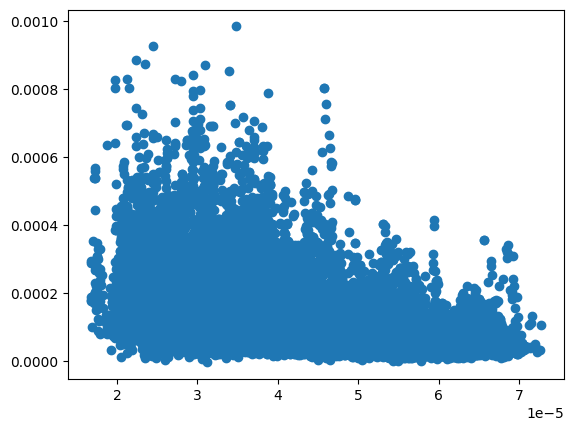

In [14]:
x = data['NO2_strat']
y = data['NO2_trop']

# Scatter plot of y vs x using scatter() and `show()` display all open figures
plt.scatter(x, y)
plt.show()

Create a jointplot showing "GT_NO2" versus "CloudFraction".

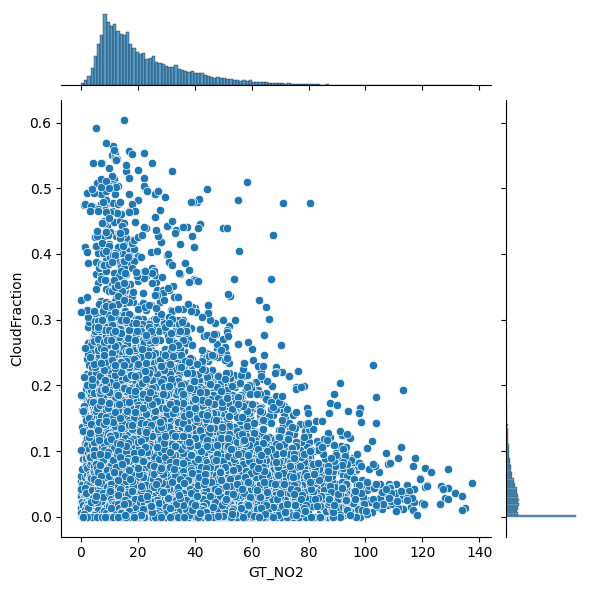

In [15]:
# `joinplot()` draws a plot of two variables with bivariate and univariate graphs.
sns.jointplot(x='GT_NO2',y='CloudFraction',data=data)

<Axes: xlabel='year', ylabel='count'>

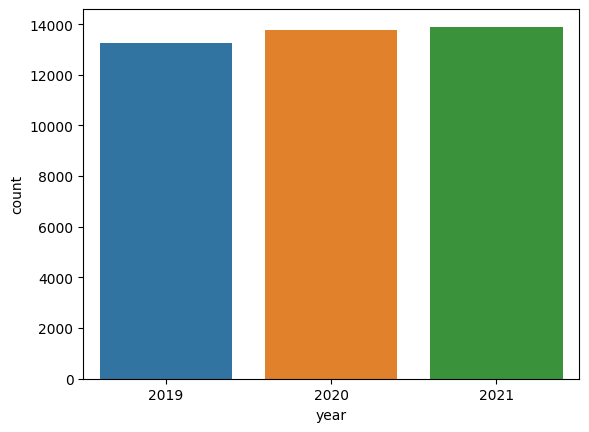

In [16]:
# `countplot()` shows the counts of observations in each categorical bin using bars
sns.countplot(x = 'year', data=data)

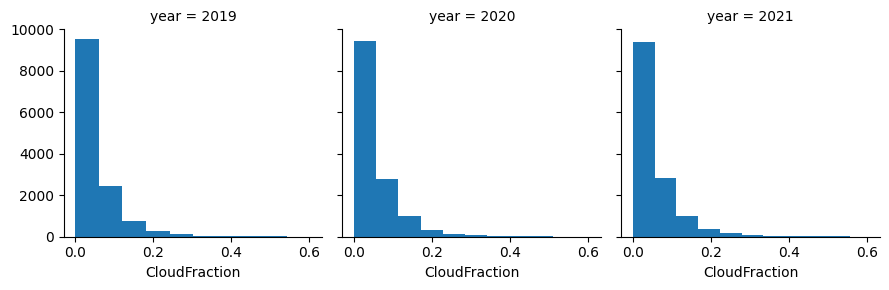

In [17]:
# takes numeric only?
# plt.figure(figsize=(20,20))
# Draw a multi-plot on every facet using `FacetGrid()`
g = sns.FacetGrid(data, col="year")
# Pass a function and the name of one or more columns in the dataframe
g.map(plt.hist, "CloudFraction");

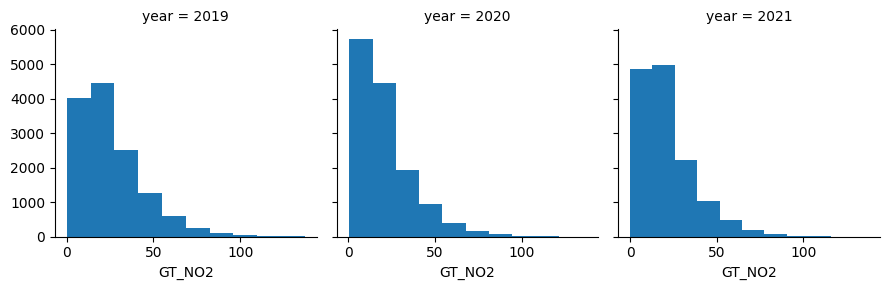

In [18]:

# plt.figure(figsize=(20,20))
# Draw a multi-plot on every facet using `FacetGrid()`
g = sns.FacetGrid(data, col="year")
# Pass a function and the name of one or more columns in the dataframe
g.map(plt.hist, "GT_NO2");

In [19]:
data.head()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,year,month,day
11,45.713559,11.367657,0.0,275.18,-0.159398,0.000000,0.000024,0.000101,0.000084,14422.64906,39.000,2019,1,1
15,45.690429,9.484261,0.0,281.48,-0.531419,0.140807,0.000023,0.000245,0.000288,14429.31480,15.925,2019,1,1
16,45.619244,8.756970,0.0,282.98,-0.580316,0.121120,0.000023,0.000156,0.000133,14425.69705,27.775,2019,1,1
25,45.649703,9.601223,0.0,282.66,-0.591821,0.151411,0.000023,0.000266,0.000159,14436.04415,13.875,2019,1,1
27,45.601232,9.275073,0.0,281.06,-0.512341,0.164469,0.000023,0.000245,0.000222,14433.50968,30.425,2019,1,1


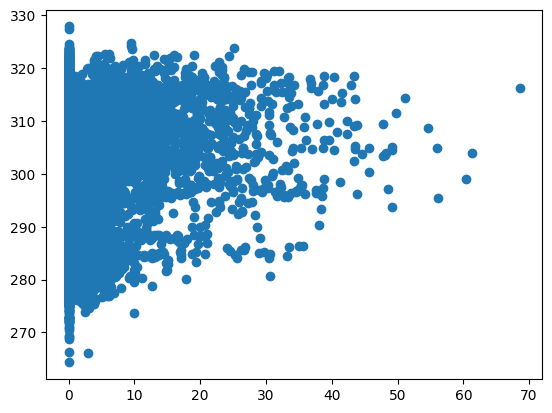

In [20]:
x = data['Precipitation']
y = data['LST']

# Scatter plot of y vs x and display all open figures
plt.scatter(x, y)
plt.show()

Let's separate the target column from features

In [21]:
y = data[['GT_NO2']]
X = data.drop(['GT_NO2'], axis=1)

In [22]:
# checking the shape of the dataset
X.shape , y.shape

((40927, 13), (40927, 1))

In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

let's build our baseline model

In [24]:
# Define your regressor
tree_regressor = DecisionTreeRegressor(random_state=42)

# Define the k-fold cross-validation 
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define a scoring function for RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Perform cross-validation and calculate RMSE for each fold
cv_scores = cross_val_score(tree_regressor, X, y, cv=kf, scoring=rmse_scorer)

# Output the RMSE for each fold and the average RMSE
print(f"RMSE for each fold: {cv_scores}\n")
print(f"Average RMSE: {np.mean(cv_scores):.3f}")

RMSE for each fold: [11.01890978 11.40451932 11.27128379]

Average RMSE: 11.232


# Feature selection techniques

## Filter Method

1. Univariate Selection:

Statistical tests can be used to select those features that have the strongest relationship with the output variable. The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

The example below uses the f_regression function in scikit-learn performs univariate linear regression tests to evaluate the relationship between each feature and the target from the GeoAI Ground-level NO2 Estimation  Dataset. The goal is to select features that have the strongest linear relationship with the target.

In [25]:
from sklearn.feature_selection import SelectKBest, f_regression

# Apply SelectKBest with f_regression (for continuous data)
bestfeatures = SelectKBest(score_func=f_regression, k=5)
fit = bestfeatures.fit(X, y)

# Create DataFrame with scores
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concatenate for visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  # Naming the columns
featureScores

,Specs,Score
0,LAT,1837.343393
1,LON,176.817806
2,Precipitation,311.122837
3,LST,15801.790735
4,AAI,1445.269622
5,CloudFraction,55.359563
6,NO2_strat,19827.107477
7,NO2_total,38530.148112
8,NO2_trop,46394.424717
9,TropopausePressure,292.085266


In [26]:
print(featureScores.nlargest(5,'Score'))  #print 5 best features

       Specs         Score
8   NO2_trop  46394.424717
7  NO2_total  38530.148112
6  NO2_strat  19827.107477
3        LST  15801.790735
0        LAT   1837.343393


In [27]:
col = ['NO2_trop','NO2_total','NO2_strat','LST','LAT']

new_x = X[col]

In [28]:
# Define the k-fold cross-validation 
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define a scoring function for RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Perform cross-validation and calculate RMSE for each fold
cv_scores = cross_val_score(tree_regressor, new_x, y, cv=kf, scoring=rmse_scorer)

# Output the RMSE for each fold and the average RMSE
print(f"RMSE for each fold: {cv_scores}\n")
print(f"Average RMSE: {np.mean(cv_scores):.3f}")

RMSE for each fold: [12.4681138  12.39485043 12.28167413 11.95859206 12.442345  ]

Average RMSE: 12.309


2. Correlation Matrix with Heatmap

Correlation states how the features are related to each other or the target variable. It can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

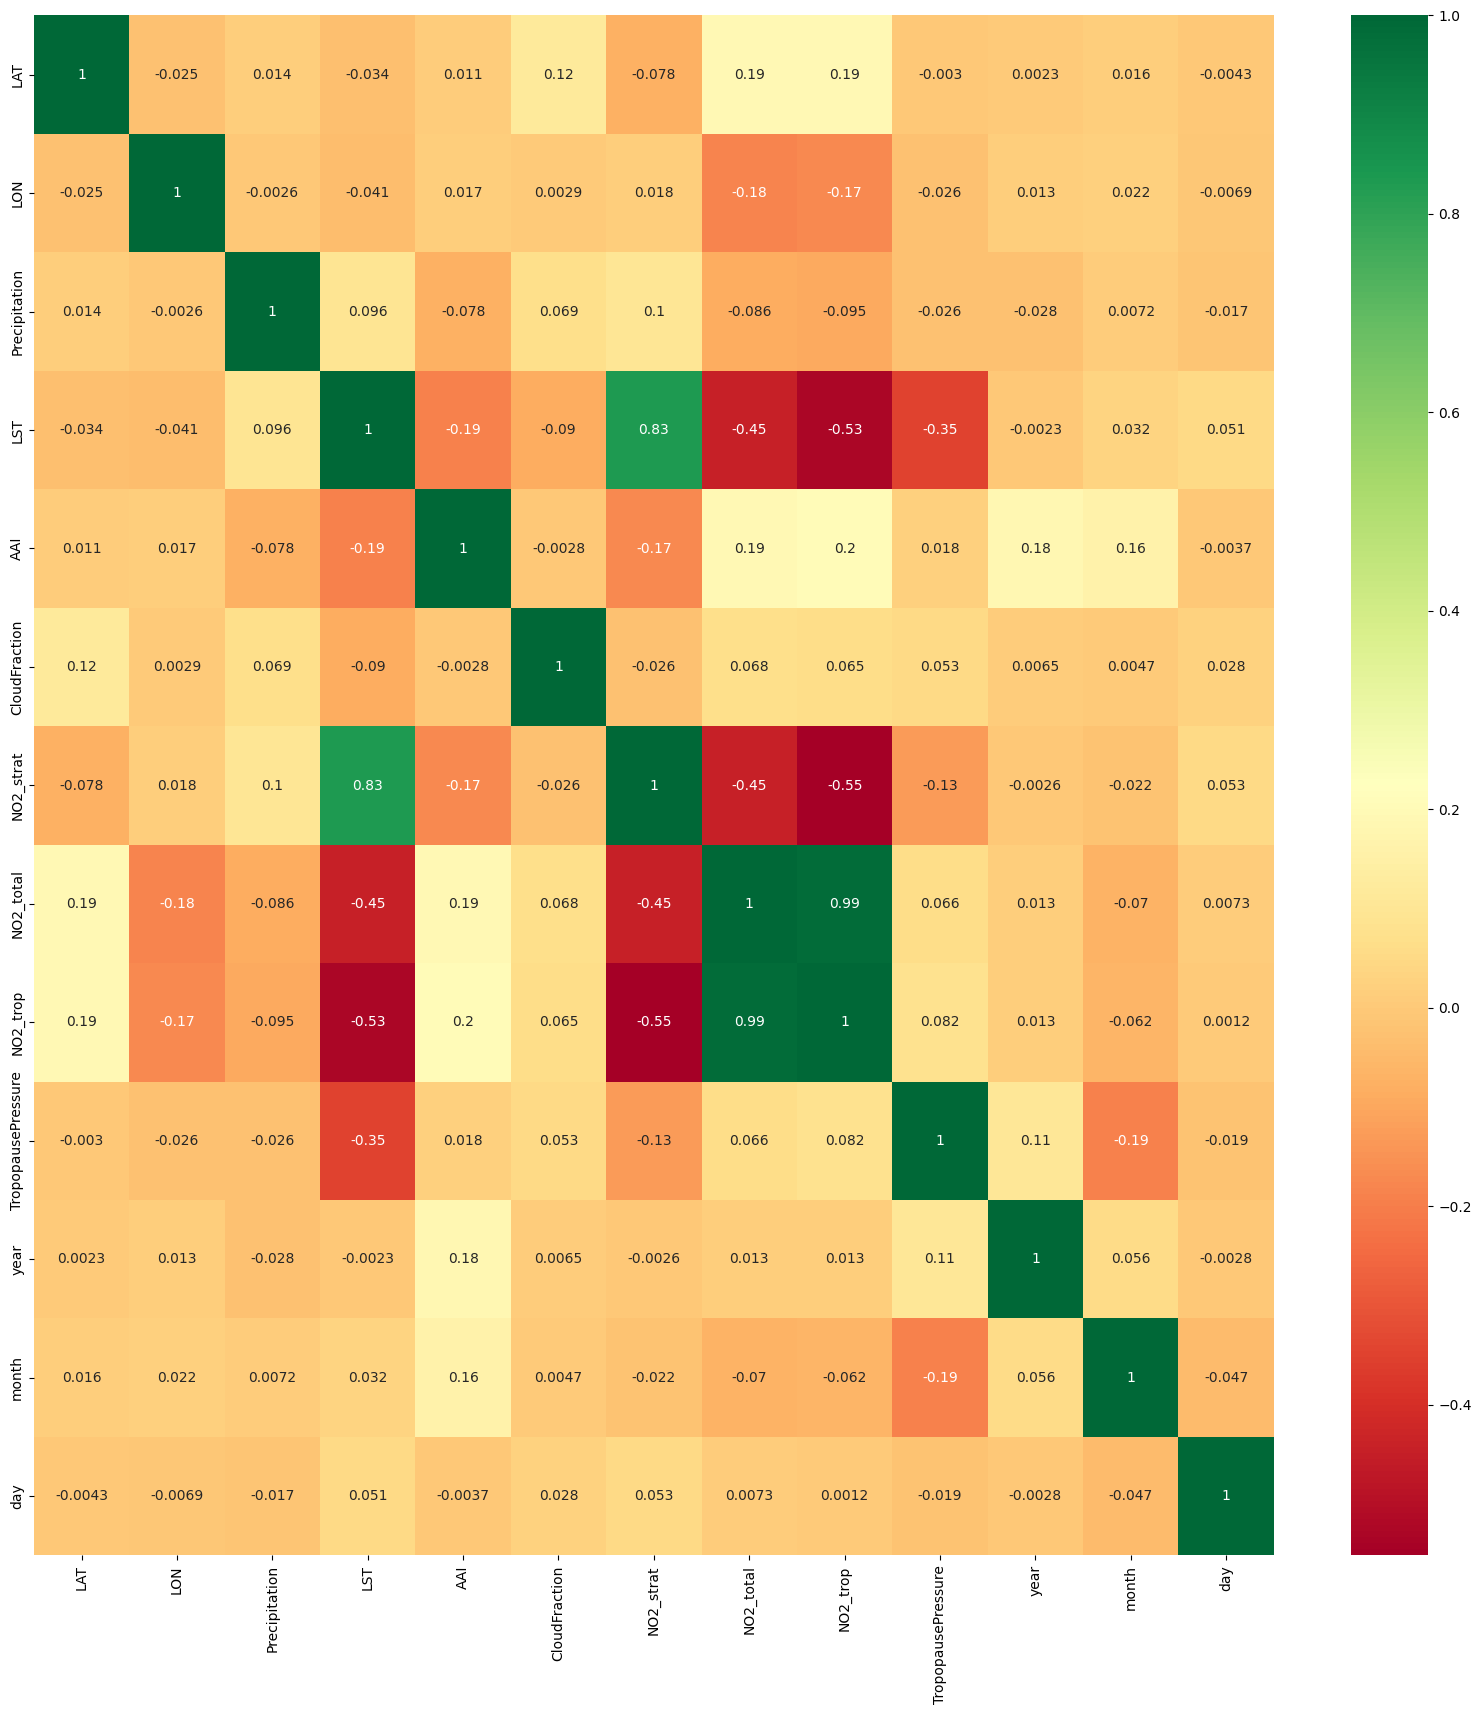

In [29]:
# Select only numerical features
train_num_df = X.select_dtypes(include=['number'])

#get correlations of each features in dataset
corrmat = train_num_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train_num_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [30]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.5)
len(set(corr_features))

corr_features

{'NO2_strat', 'NO2_trop'}

In [31]:
col = ['LST', 'NO2_strat', 'NO2_total']

new_ = X[col]

In [32]:
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Define k-fold cross-validation 
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define RMSE as a scoring function
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Perform cross-validation and calculate RMSE for each fold
cv_scores = cross_val_score(rf_regressor, new_, y, cv=kf, scoring=rmse_scorer)

# Output the RMSE for each fold and the average RMSE
print("RMSE for each fold:", cv_scores)
print(f"Average RMSE: {np.mean(cv_scores):.3f}")

RMSE for each fold: [11.12885389 11.1475269  10.88720403 10.72880171 10.85861689]
Average RMSE: 10.950


## Wrapper Method

1. Recursive feature elimination (RFE)

In [33]:
import xgboost as xgb
from sklearn.feature_selection import RFE

# defining X_train_v3, y_train_v3, X_test_v3, and y_test_v3 
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

# Initialize the XGBoost regressor
model = xgb.XGBRegressor(random_state=42)

rfe_rmse_list = []

for k in range(1, 14):
    RFE_selector = RFE(estimator=model, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train_v3, y_train_v3)
    
    sel_X_train_v3 = RFE_selector.transform(X_train_v3)
    sel_X_test_v3 = RFE_selector.transform(X_test_v3)
    
    model.fit(sel_X_train_v3, y_train_v3)
    RFE_preds = model.predict(sel_X_test_v3)
    
    # Calculate RMSE
    rmse_rfe = np.sqrt(mean_squared_error(y_test_v3, RFE_preds))
    
    rfe_rmse_list.append(rmse_rfe)

# Output the RMSE results
for k, rmse in enumerate(rfe_rmse_list, start=1):
    print(f'Number of features: {k}, RMSE: {rmse:.3f}')


Number of features: 1, RMSE: 11.302
Number of features: 2, RMSE: 9.614
Number of features: 3, RMSE: 9.631
Number of features: 4, RMSE: 9.146
Number of features: 5, RMSE: 7.885
Number of features: 6, RMSE: 7.414
Number of features: 7, RMSE: 6.872
Number of features: 8, RMSE: 7.021
Number of features: 9, RMSE: 6.980
Number of features: 10, RMSE: 6.940
Number of features: 11, RMSE: 6.824
Number of features: 12, RMSE: 6.894
Number of features: 13, RMSE: 6.834


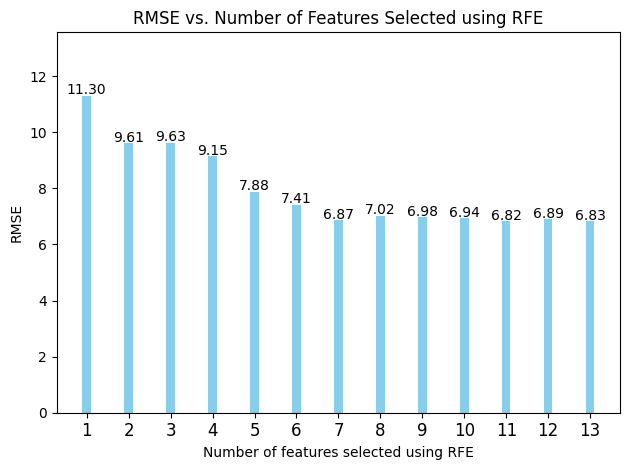

In [34]:
import matplotlib.pyplot as plt

# Assuming you already have the rfe_rmse_list from the previous code
fig, ax = plt.subplots()

x = np.arange(1, 14)  # Number of features from 1 to 13
y = rfe_rmse_list  # RMSE values from RFE

# Create a bar plot
ax.bar(x, y, width=0.2, color='skyblue')

# Set labels and title
ax.set_xlabel('Number of features selected using RFE')
ax.set_ylabel('RMSE')
ax.set_ylim(0, np.max(y) * 1.2)  # Adjust y-limit for better visualization
ax.set_xticks(np.arange(1, 14))
ax.set_xticklabels(np.arange(1, 14), fontsize=12)

# Annotate each bar with its RMSE value
for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=f'{v:.2f}', ha='center', fontsize=10)

plt.title('RMSE vs. Number of Features Selected using RFE')
plt.tight_layout()
plt.show()


In [35]:
# Set up RFE for regression
RFE_selector = RFE(estimator=model, n_features_to_select=4, step=1)  # Adjust step as needed
RFE_selector.fit(X_train_v3, y_train_v3)

# Get the mask of selected features
selected_features_mask = RFE_selector.get_support()

# Get the names of the selected features
selected_features = X_train_v3.columns[selected_features_mask]

# Output the selected features
print("Selected Features:", selected_features.tolist())

Selected Features: ['LAT', 'LON', 'NO2_trop', 'year']


2. Boruta

In [36]:
X_train_v4, X_test_v4, y_train_v4, y_test_v4 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [40]:
from boruta import BorutaPy
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor

# Monkey patch for deprecated NumPy types
import numpy as np
np.int = int
np.float = float
np.bool = bool

# Initialize the XGBoost Regressor
gbc = XGBRegressor(random_state=42)

# Initialize Boruta selector
boruta_selector = BorutaPy(gbc, random_state=42)

# Fit the selector to the training data
boruta_selector.fit(X_train_v4.values, y_train_v4.values.ravel())

# Transform the data using the selector
sel_X_train_v4 = boruta_selector.transform(X_train_v4.values)
sel_X_test_v4 = boruta_selector.transform(X_test_v4.values)

# Fit the model to the selected features
gbc.fit(sel_X_train_v4, y_train_v4)

# Make predictions on the test set
boruta_preds = gbc.predict(sel_X_test_v4)

# Calculate RMSE
boruta_rmse = np.sqrt(mean_squared_error(y_test_v4, boruta_preds))

# Print the RMSE
print("RMSE:", boruta_rmse)

RMSE: 6.743732451085506


In [38]:
selected_features_mask = boruta_selector.support_

selected_features = X_train_v4.columns[selected_features_mask]
selected_features

Index(['LAT', 'LON', 'LST', 'AAI', 'CloudFraction', 'NO2_strat', 'NO2_total',
       'NO2_trop', 'TropopausePressure', 'year', 'month', 'day'],
      dtype='object')

3. Sequential Feature Selection

Foward Selection


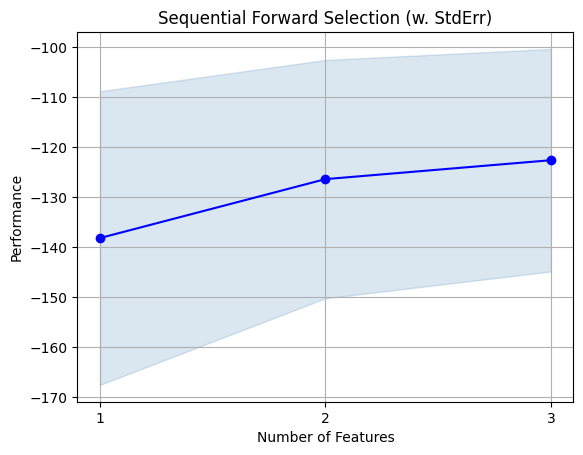

In [7]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


lr = LinearRegression()

sfs = SFS(lr, 
          k_features=3, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [8]:
# Get the names of the selected features
selected_features = sfs.k_feature_names_

# Print the selected features
print("Selected Features:", selected_features)

Selected Features: ('NO2_strat', 'NO2_trop', 'year')


In [9]:
col1 = ['NO2_strat', 'NO2_trop', 'year']
fs = data[col1]

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model1 = LinearRegression()

rmse_list = []

# K-fold cross-validation
for train_index, test_index in kf.split(fs):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model1.fit(X_train, y_train)
    
    # Make predictions
    predictions = model1.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_list.append(rmse)

# Average RMSE over all folds
average_rmse = np.mean(rmse_list)
print(f'Average RMSE across all folds: {average_rmse:.3f}')

Average RMSE across all folds: 10.780


# Embedded Methods


Feature Importance Using Random Forest

Number of features: 13
Average RMSE across all folds: 7.517


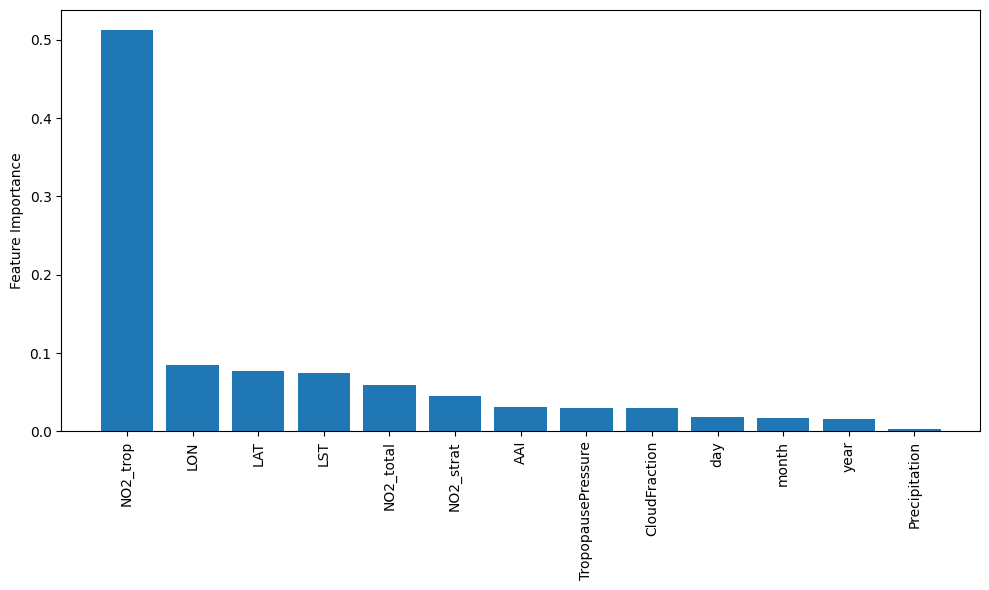

In [10]:
# Initialize the Random Forest Regressor
forest = RandomForestRegressor(random_state=42)

# Initialize k-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=42)

rmse_list = []
feature_importances = np.zeros(X.shape[1])

# K-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    forest.fit(X_train, y_train)
    
    # Make predictions
    predictions = forest.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_list.append(rmse)

    # Aggregate feature importances
    feature_importances += forest.feature_importances_

# Average feature importances
feature_importances /= kf.n_splits

print(f'Number of features: {X.shape[1]}')

# Average RMSE over all folds
average_rmse = np.mean(rmse_list)
print(f'Average RMSE across all folds: {average_rmse:.3f}')

# Plot feature importance
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.ylabel('Feature Importance')
plt.bar(range(X.shape[1]), 
        feature_importances[indices],
        align='center')

feat_labels = X.columns
plt.xticks(range(X.shape[1]), 
           np.array(feat_labels)[indices], rotation=90)

plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()